# Momentum Strategy

In [ ]:
%pip install python-dotenv
%pip install matplotlib
%pip install seaborn
%pip install plotly

%pip install yfinance

In [12]:
# Grab Data
import yfinance as yf

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

ALPHA_ADVANTAGE_KEY = os.getenv('ALPHA_ADVANTAGE_KEY')

In [3]:
# Get the stock data
raw = yf.download('^XAU', start='2013-01-01', end='2023-02-28')
data = pd.DataFrame(raw)

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,166.220001,169.970001,166.220001,168.470001,168.470001,0
2013-01-03,167.610001,168.600006,161.740005,162.160004,162.160004,0
2013-01-04,161.229996,162.669998,159.910004,162.529999,162.529999,0
2013-01-07,161.690002,161.839996,159.979996,160.199997,160.199997,0
2013-01-08,160.279999,160.800003,158.679993,160.550003,160.550003,0


In [5]:
data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

<Axes: xlabel='Date'>

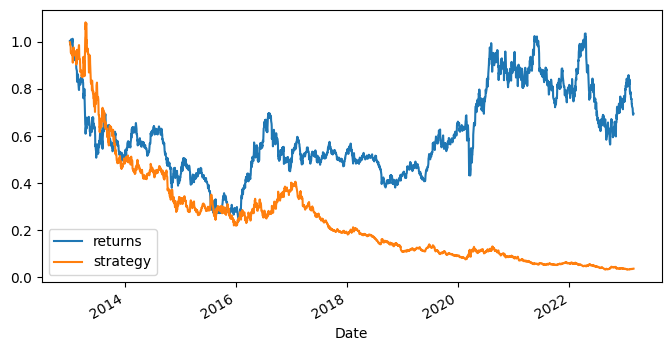

In [6]:
# If the last return was positive --> buy
# If the last return was negative --> sell
data['position'] = np.sign(data['returns'])
data['strategy'] = data['position'].shift(1) * data['returns']

data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(8, 4))

Well, that sucked

<Axes: xlabel='Date'>

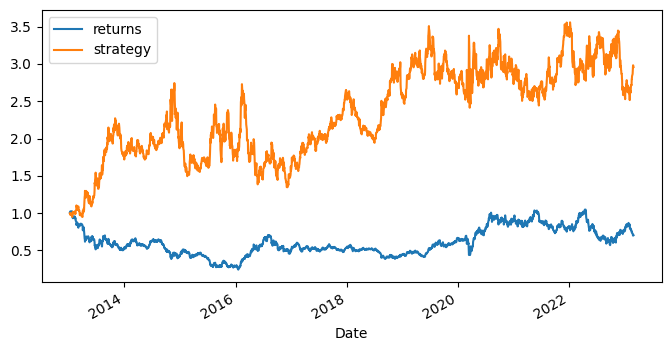

In [9]:
# If the average last 3 returns are positive --> buy
# If the average last 3 returns are negative --> sell
data['position'] = np.sign(data['returns'].rolling(3).mean())

data['strategy'] = data['position'].shift(1) * data['returns']

data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(8, 4))

Much better. However, this strategy is better for intraday

In [19]:
raw =f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=AAPL&interval=1min&datatype=csv&outputsize=compact&apikey={ALPHA_ADVANTAGE_KEY}'

In [20]:
df = pd.read_csv(raw)
df = pd.DataFrame(df)

df.head()

,timestamp,open,high,low,close,volume
0,2023-08-02 19:59:00,192.82,192.92,192.80,192.81,8938
1,2023-08-02 19:58:00,192.82,192.93,192.82,192.82,2038
2,2023-08-02 19:57:00,192.80,192.82,192.74,192.80,6989
3,2023-08-02 19:56:00,192.78,192.78,192.72,192.77,1193
4,2023-08-02 19:55:00,192.75,192.80,192.70,192.80,1938


In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.sort_values('timestamp', ascending=True, inplace=True)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2023-08-02 18:20:00,192.510,192.54,192.510,192.52,527
2023-08-02 18:21:00,192.520,192.58,192.520,192.58,5563
2023-08-02 18:22:00,192.580,192.65,192.555,192.65,4972
2023-08-02 18:23:00,192.635,192.75,192.590,192.64,1072
2023-08-02 18:24:00,192.640,192.75,192.625,192.66,1438


In [22]:
df['returns'] = np.log(df['close'] / df['close'].shift(1))

to_plot = ['returns']

In [23]:
# Rolling momentum of five different averages
for m in [1, 3, 5, 7, 9]:
    df['position_%d' % m] = np.sign(df['returns'].rolling(m).mean())
    df['strategy_%d' % m] = (df['position_%d' % m].shift(1) * df['returns'])
    to_plot.append('strategy_%d' % m)

<Axes: title={'center': 'AAPL Intraday'}, xlabel='timestamp'>

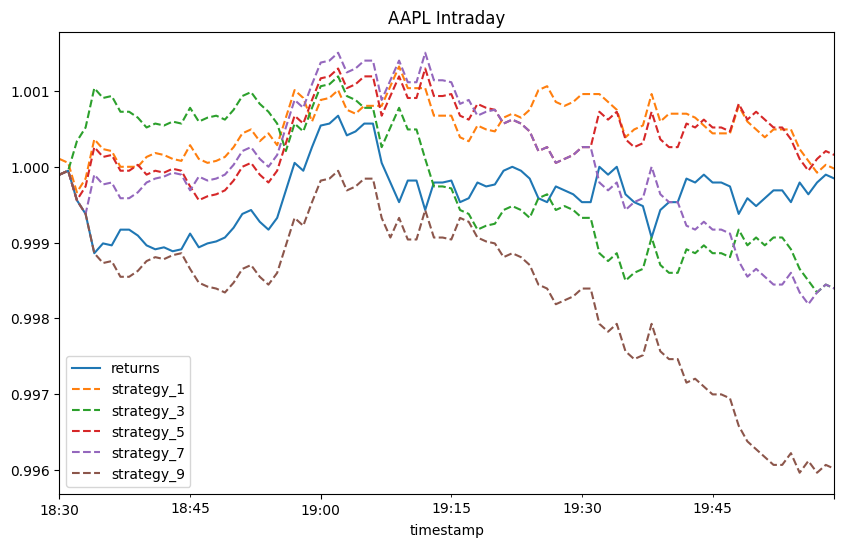

In [25]:
# plot
df[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='AAPL Intraday',
    figsize=(10,6), style=['-', '--', '--', '--', '--', '--']
)

I would assume your shortest times don't work because Momentum has a tendency to reverse when looking at periods less than 2 weeks. The shorter the period the higher the tendency to reverse. Momentum funds usually round this up to a full month of exclusion from their calculations and then calculate 6 month Momentum and 12 month (excluding most recent) Momentum for future expected outperformance. Buy stocks that aren't microcaps with the highest Momentum based on that. Then they hold for a quarter usually.

So what could be more interesting is to first calculate the ideal candidate to hold based on those metrics and then use higher frequencies for figuring out when that Momentum is reversing and get out.